In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pandas as pd
#import uproot
import uproot3
from scipy import optimize as op
import scipy.integrate as integrate

In [2]:
#Gain access to functions used to change some of the aspects regarding arrays and the things in them
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Bin\ Conversions.ipynb

#Gain Access to functions used to work with momentum binning
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Momentum\ Bins.ipynb

#Gain Access to functions used to work with Fitting Functions
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Fitting\ Functions.ipynb

#Gain Access to functions used for TH2s 
#uproot or uproo4
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/TH2\ Functions-uproot3.ipynb
#uproot3
#%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/TH1\ Functions-uproot3.ipynb

#Gain Access to functions for taking discrete derivatives of lists of data
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Derivatives.ipynb

*Bin Conversions*
Available Functions:
Note: All functions return new arrays rather than altering the previous array
	New_Merged_Size(array_,merge_size_) returns what the size of the new merged array will be
	Merge_Bin_Edges(edges_,merge_size) merges the bin edges 
	Merge_Bins(array_,merge_size_) adds together every <merge_size_> values in an array
	Merge_Vals(yarray_,merge_size_) adds together every <merge_size_> ybin together in an array
	Merge_Bins(xarray_,merge_size_) averages every <merge_size_> xbins together in an array
	Count_Non_Zero(array_) counts the number of nonzero values in an array
	Count_Zero(array_) counts the number of zeros in an array
	Remove_Zeros(array_) remove zeros from an array
	Remove_Zeros_Y(yarray_) removes zero values from yarray
	Remove_Zeros_X(xarray_,yarray_) removes xbins where the corresponding y value was zero
	Count_InBounds(yarray_,low_,high_) counts the number of values that fall between bounds (or equal to)
	Count_OutBounds(yarray_,low_,high_) co

In [3]:
date="05-06-2024"
dir="/Users/cmc/analysis_phd/root_files/cut_determination/cut_det_e16/"+date
#dir="/Users/cmc/analysis_phd/root_files/cut_determination/cut_det_e16/"+date+"/cc"
#dir="/Users/cmc/analysis_phd/root_files/local_runs/e16/target"
#root_file=dir+"/analysis_full_e16_geo_fid.root"
root_file=dir+"/sim_e16_clas6_fid_geo_"+date+".root"
file=uproot3.open(root_file)

species="ele"
detector="ec"
cut="pid"

sector_names = ["sec1","sec2","sec3","sec4","sec5","sec6","all"]
side = ["left","coinc","right","All"]
num_cc_seg = 18
num_cc_side = 3
num_sc_pad = 48
#0-> pid | 1->event selection all 

color_order = ['b','g','r']
rv_color_order = ['r','g','b']
cut_name = ['tight','mid','loose']
rv_cut_name = ['loose','mid','tight']

In [4]:
layer1="Geometric Distributions"
layer2="Geo Fid "+species
layer3=layer2+" "+detector
layer4=[layer3+" "+sector_names[sec] for sec in range(7)]
layer5=[layer4[sec]+" "+cut for sec in range(7)]

    

In [5]:
hist_idx_len = len(file[layer1+"/"+layer2+"/"+layer3+"/"+layer4[0]+"/"+layer5[0]].keys())

#hist = [[file[layer1+"/"+layer2+"/"+layer3+"/"+layer4[sec]+"/"+layer5[sec]][file[layer1+"/"+layer2+"/"+layer3+"/"+layer4[sec]+"/"+layer5[sec]].keys()[2*hist_idx]] for hist_idx in range(round(hist_idx_len/2))] for sec in range(7)]
hist = [[file[layer1+"/"+layer2+"/"+layer3+"/"+layer4[sec]+"/"+layer5[sec]][file[layer1+"/"+layer2+"/"+layer3+"/"+layer4[sec]+"/"+layer5[sec]].keys()[hist_idx]] for hist_idx in range(round(hist_idx_len))] for sec in range(7)]


cut_hist_len = round(hist_idx_len/2)#4)

In [6]:
def x_idx(xarray_, xval_):
    for i in range(len(xarray_)):
        if xarray_[i] <= xval_:
            if xarray_[i+1] >= xval_:
                return i
    return -1

def y_idx(yarray_, yval_):
    for i in range(len(yarray_)):
        if yarray_[i] <= yval_:
            if yarray_[i+1] >= yval_:
                return i
    return -1

In [7]:
#For cut only
def side_idx(hist_idx_):
    if hist_idx_ < num_cc_seg*3:
        if hist_idx_ < num_cc_seg:
            return 0
        elif hist_idx < num_cc_seg*2:
            return 1
        else:
            return 2
    elif hist_idx_ <= num_cc_seg*3+3:
        return hist_idx_ - (num_cc_seg*3)

def seg_idx(hist_idx_):
    if hist_idx_ < num_cc_seg*3:
        if hist_idx_ < num_cc_seg:
            return hist_idx_
        elif hist_idx < num_cc_seg*2:
            return hist_idx_ - num_cc_seg
        else:
            return hist_idx_ - num_cc_seg*2
    elif hist_idx_ <= num_cc_seg*3+3:
        return _num_cc_seg
    
def pad_idx(hist_idx_):
    if hist_idx_ <= _num_sc_pad:
        return hist_idx_ 
    else:
        return -1
    
def cc_hist_idx(side_, seg_):
    if side_ == 3:
        if seg_ == num_cc_seg:
            return cut_hist_len-1
        else:
            return -1
    else:
        if seg_ == num_cc_seg:
            return num_cc_seg*3 + side_
        else:
            return num_cc_seg*side_ + seg_


In [8]:
#Look at Overall Distributions
xdim_len = len(Center_Xbins(hist[0][0]))
ydim_len = len(Center_Ybins(hist[0][0]))

x_merge = 1
y_merge = 1


xvals = Merge_Bins(Center_Xbins(hist[0][0]),x_merge)
yvals = Merge_Bins(Center_Ybins(hist[0][0]),y_merge)
zvals_xy = [[Merge_Z(XY_Values(hist[sec][hist_idx]),x_merge,y_merge) for hist_idx in range(cut_hist_len)] for sec in range(7)]
zvals_yx = [[Merge_Z(YX_Values(hist[sec][hist_idx]),y_merge,x_merge) for hist_idx in range(cut_hist_len)] for sec in range(7)]



In [9]:
xdim = len(xvals)
ydim = len(yvals)

xres = xvals[1]-xvals[0]
yres = yvals[1]-yvals[0]

def shift_idx(x_shift_):
    return round(x_shift_/xres)

In [37]:
print(yres)

1.6666666666666665


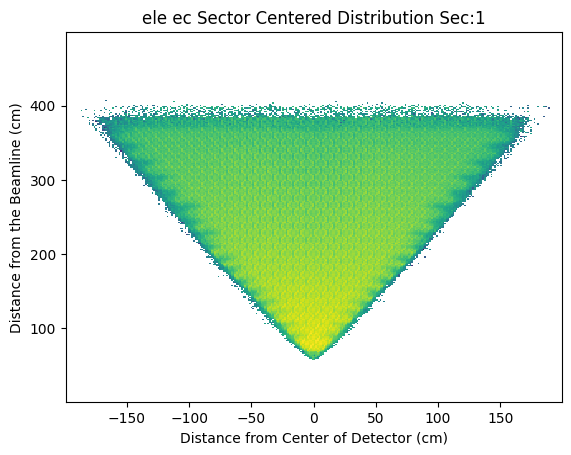

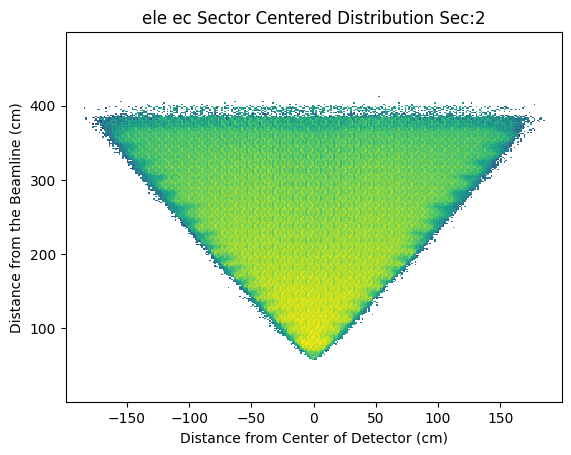

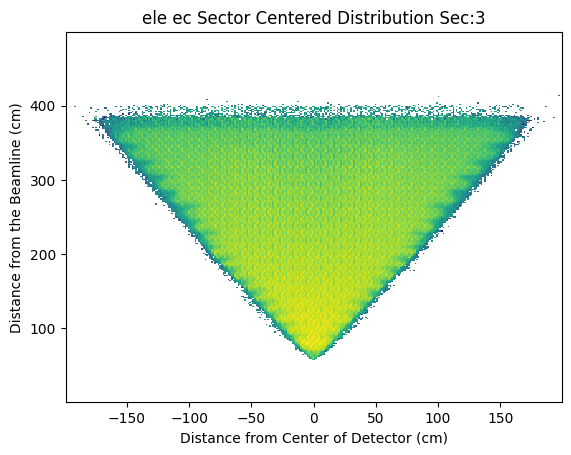

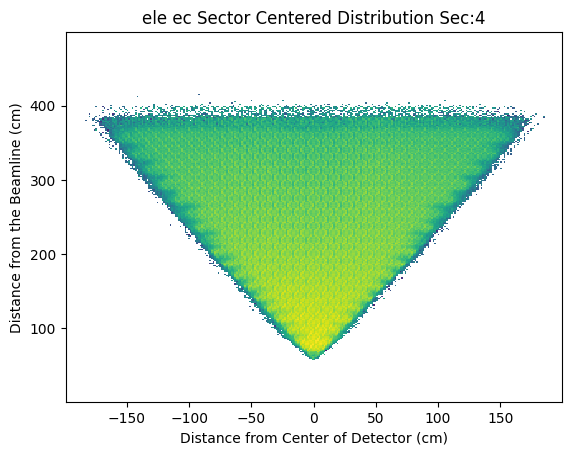

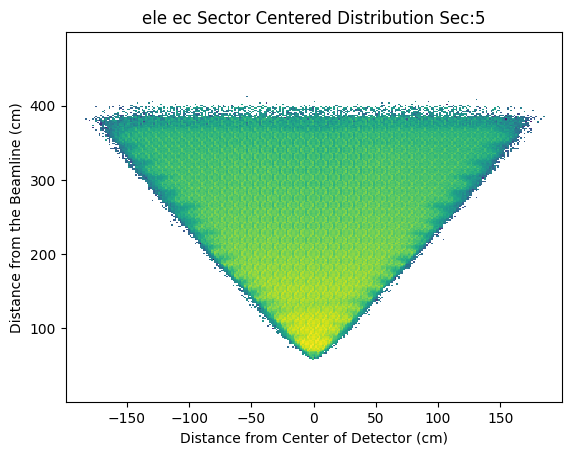

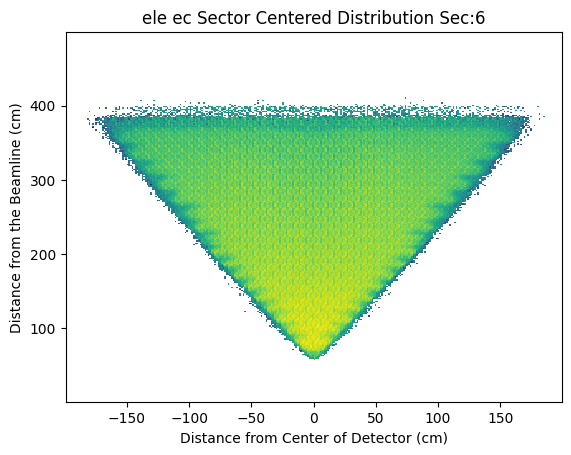

In [10]:
dumb1_x= np.zeros((7,cut_hist_len,xdim*ydim))
dumb1_y= np.zeros((7,cut_hist_len,xdim*ydim))
dense1 = np.zeros((7,cut_hist_len,xdim*ydim))
dumb2_x= np.zeros((7,cut_hist_len,xdim*ydim))
dumb2_y= np.zeros((7,cut_hist_len,xdim*ydim))
dense2 = np.zeros((7,cut_hist_len,xdim*ydim))
for sec in range(7):
    for i in range(xdim):
        for j in range(ydim):
            for hist_idx in range(cut_hist_len):
                dumb1_x[sec][hist_idx][i+j*xdim]+=xvals[i]
                dumb1_y[sec][hist_idx][i+j*xdim]+=yvals[j]
                dense1[sec][hist_idx][i+j*xdim]+=zvals_xy[sec][hist_idx][i][j]
                dumb2_x[sec][hist_idx][j+i*ydim]+=yvals[j]
                dumb2_y[sec][hist_idx][j+i*ydim]+=xvals[i]
                dense2[sec][hist_idx][j+i*ydim]+=zvals_yx[sec][hist_idx][j][i]
for sec in range(6):
    plt.hist2d(dumb1_x[sec][cut_hist_len-1], dumb1_y[sec][cut_hist_len-1], bins=(xdim, ydim), weights=dense1[sec][cut_hist_len-1],norm = mpl.colors.LogNorm())
    plt.title(species+" "+detector+" Sector Centered Distribution Sec:{}".format(sec+1))
    plt.xlabel("Distance from Center of Detector (cm)")
    plt.ylabel("Distance from the Beamline (cm)")
    plt.show()

In [11]:
print(len(zvals_yx[0]))

1


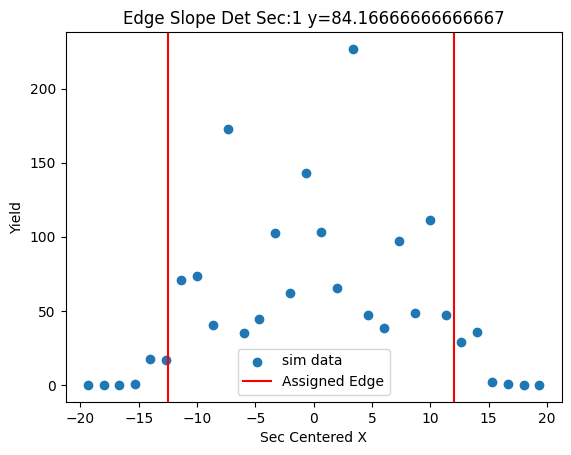

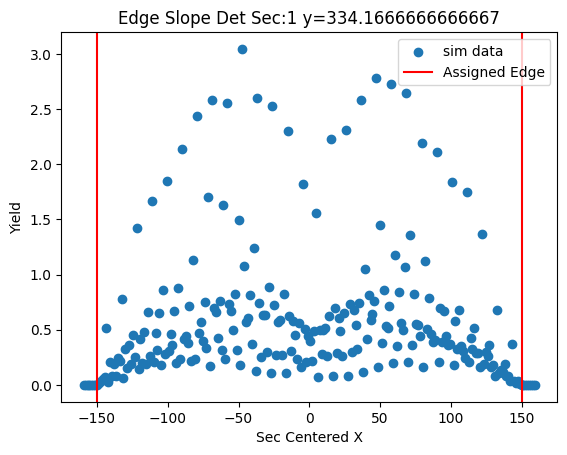

Right Slope =  1.8115942028985508
Left Slope =  -1.8181818181818181


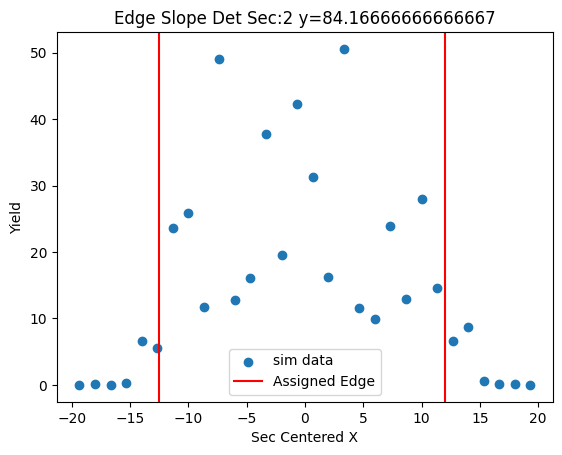

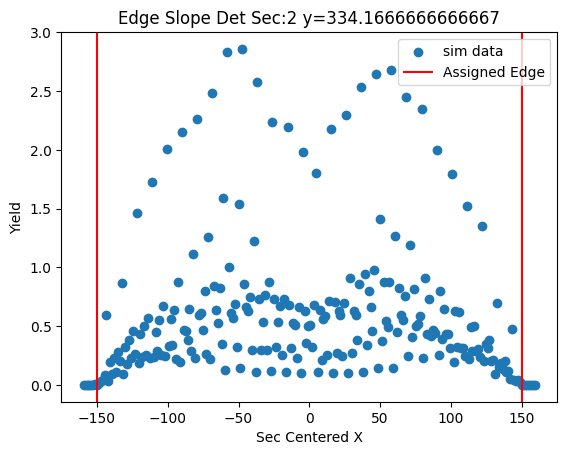

Right Slope =  1.8115942028985508
Left Slope =  -1.8181818181818181


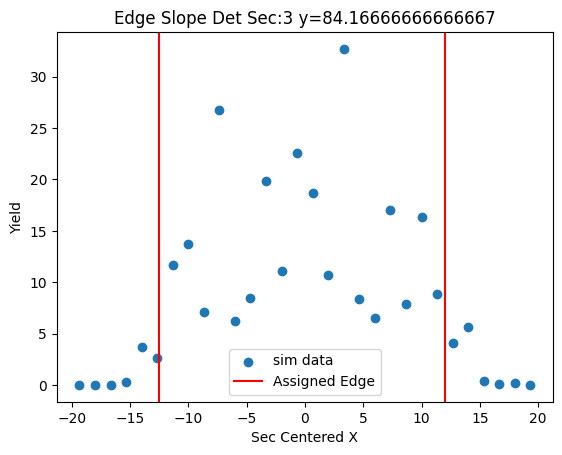

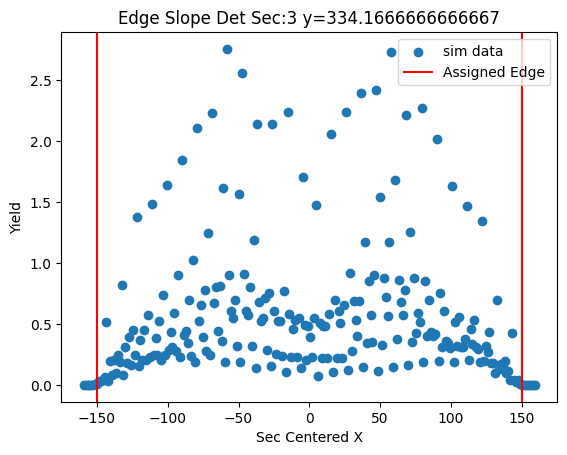

Right Slope =  1.8115942028985508
Left Slope =  -1.8181818181818181


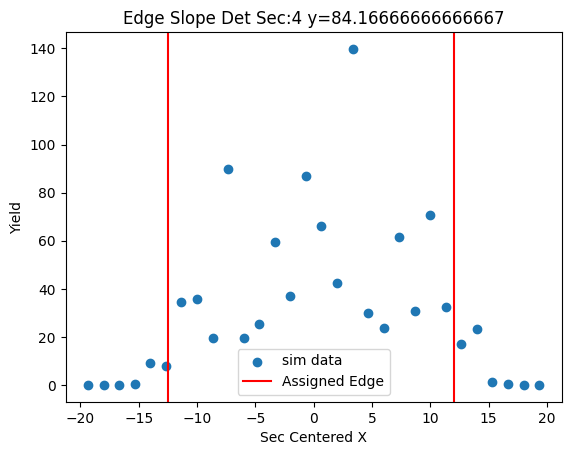

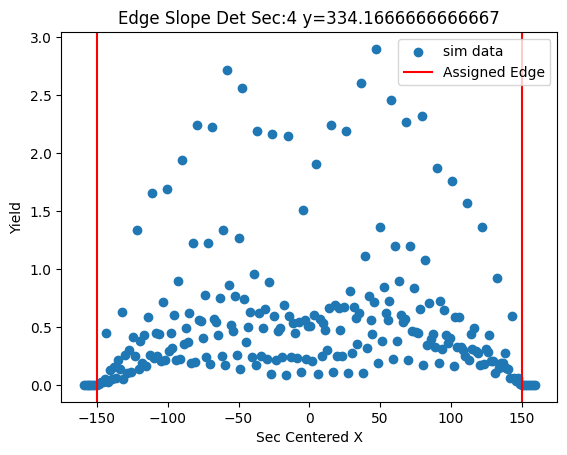

Right Slope =  1.8115942028985508
Left Slope =  -1.8181818181818181


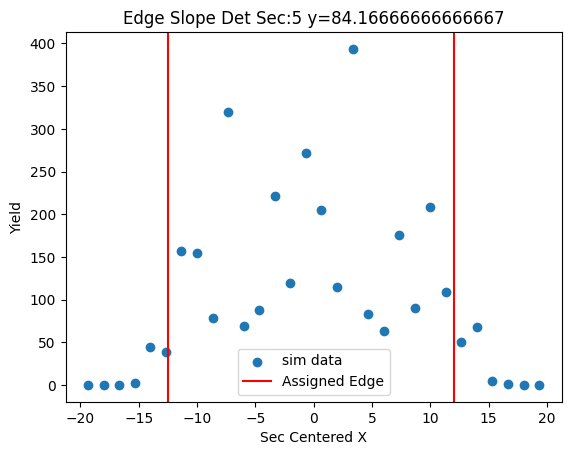

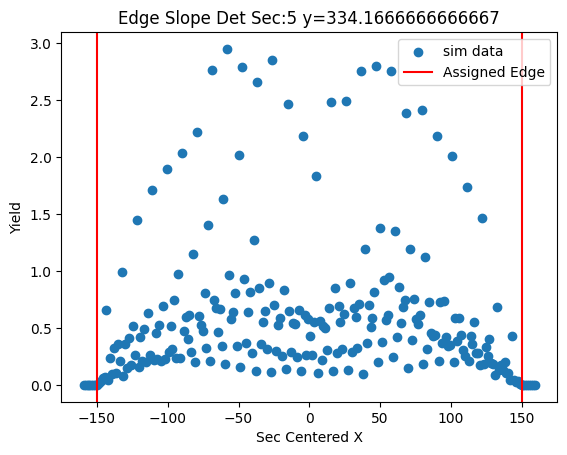

Right Slope =  1.8115942028985508
Left Slope =  -1.8181818181818181


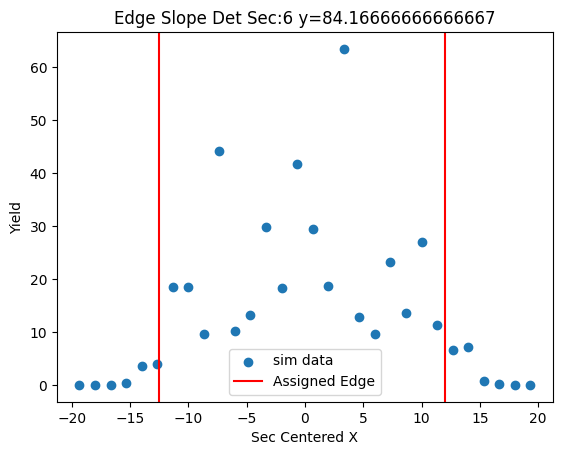

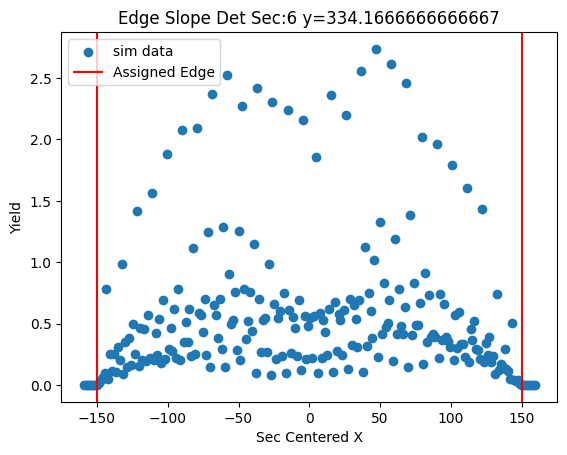

Right Slope =  1.8115942028985508
Left Slope =  -1.8181818181818181


In [12]:
yidx = [50,200]

xrange = [[[-20,20],[-160,160]],
          [[-20,20],[-160,160]],
          [[-20,20],[-160,160]],
          [[-20,20],[-160,160]],
          [[-20,20],[-160,160]],
          [[-20,20],[-160,160]]]

x_points = [[[-12.5,12],[-150,150]],
            [[-12.5,12],[-150,150]],
            [[-12.5,12],[-150,150]],
            [[-12.5,12],[-150,150]],
            [[-12.5,12],[-150,150]],
            [[-12.5,12],[-150,150]]]

right_rot = [3**(1/2),3**(1/2),3**(1/2),3**(1/2),3**(1/2),3**(1/2),3**(1/2)]
left_rot = [3**(1/2),3**(1/2),3**(1/2),3**(1/2),3**(1/2),3**(1/2),3**(1/2)]


for sec in range(6):
    for b in range(2):
        mod_xvals = Bounds_on_Y(xvals,xrange[sec][b][0],xrange[sec][b][1])
        mod_zvals = Bounds_on_X_From_Y(zvals_yx[sec][0][yidx[b]],xvals,xrange[sec][b][0],xrange[sec][b][1])
        plt.scatter(mod_xvals,mod_zvals,label="sim data")
        plt.axvline(x=x_points[sec][b][0],color='r',label="Assigned Edge")
        plt.axvline(x=x_points[sec][b][1],color='r')
        plt.title("Edge Slope Det Sec:{} y={}".format(sec+1,yvals[yidx[b]]))
        plt.xlabel("Sec Centered X")
        plt.ylabel("Yield")
        plt.legend()
        plt.show()
    right_rot[sec] =  (yvals[yidx[1]]-yvals[yidx[0]])/(x_points[sec][1][1]-x_points[sec][0][1])
    left_rot[sec] = (yvals[yidx[1]]-yvals[yidx[0]])/(x_points[sec][1][0]-x_points[sec][0][0])
    print("Right Slope = ",right_rot[sec])
    print("Left Slope = ",left_rot[sec])

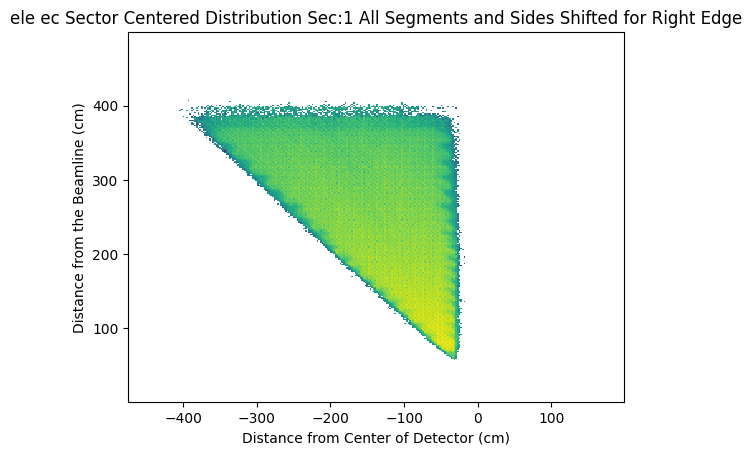

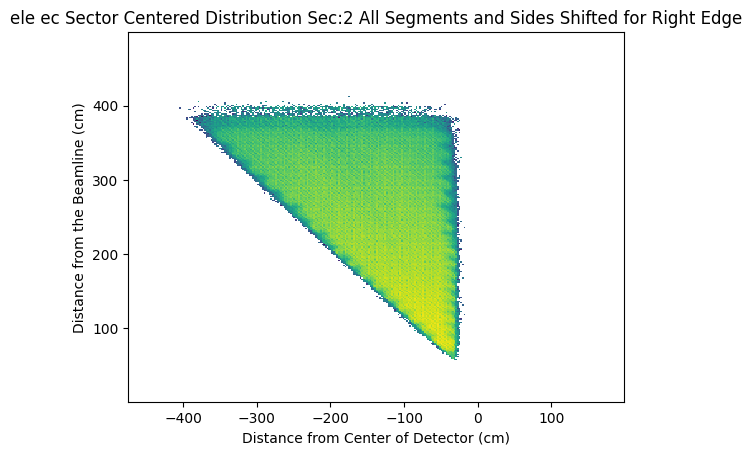

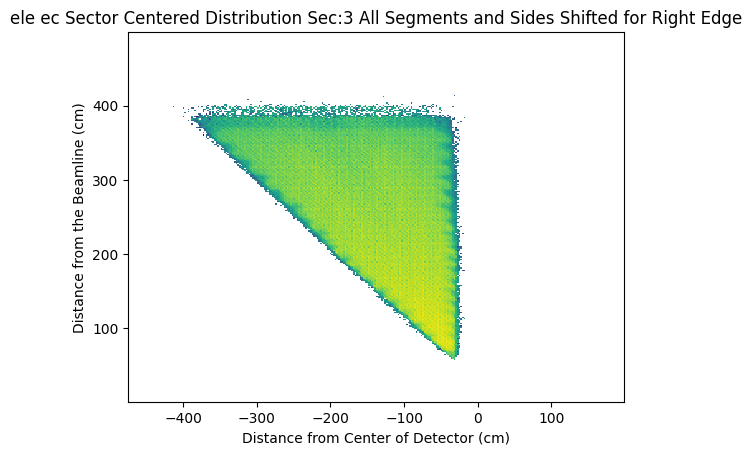

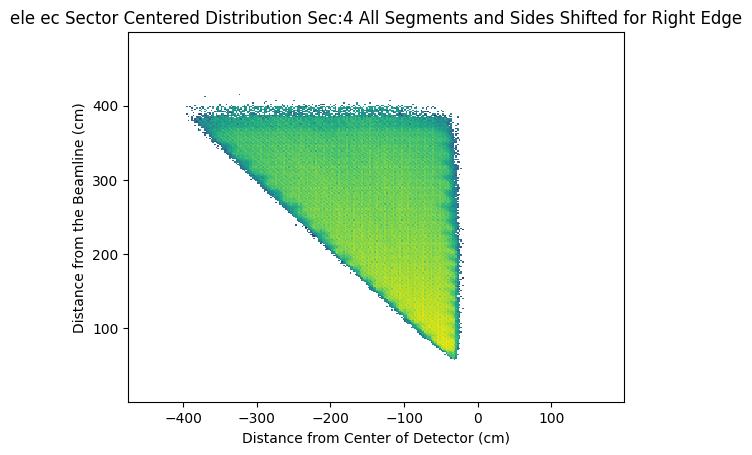

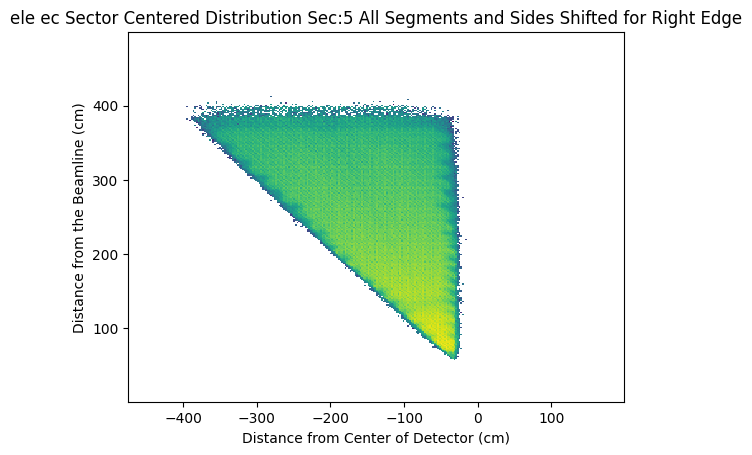

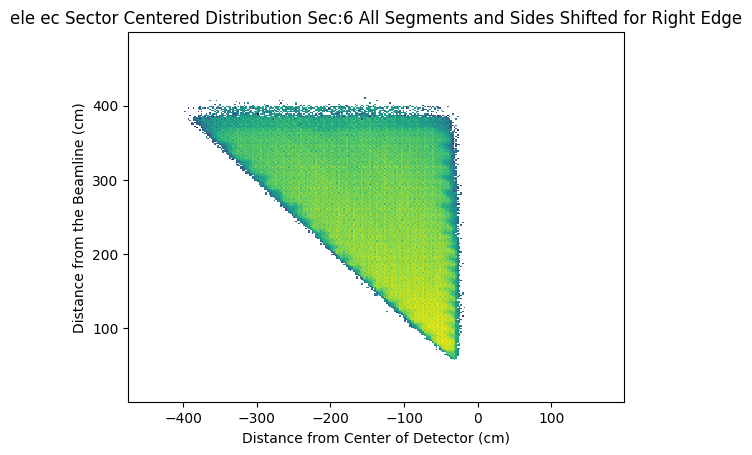

In [13]:
#Shifting for Right Edge
dumb1_x_sr= np.zeros((7,cut_hist_len,xdim*ydim))
dumb1_y_sr= np.zeros((7,cut_hist_len,xdim*ydim))
dense1_sr = np.zeros((7,cut_hist_len,xdim*ydim))
dumb2_x_sr= np.zeros((7,cut_hist_len,xdim*ydim))
dumb2_y_sr= np.zeros((7,cut_hist_len,xdim*ydim))
dense2_sr = np.zeros((7,cut_hist_len,xdim*ydim))
for sec in range(7):
    for i in range(xdim):
        for j in range(ydim):
            for hist_idx in range(cut_hist_len):
                dumb1_x_sr[sec][hist_idx][i+j*xdim]+=xvals[i]-yvals[j]/right_rot[sec]
                dumb1_y_sr[sec][hist_idx][i+j*xdim]+=yvals[j]
                dense1_sr[sec][hist_idx][i+j*xdim]+=zvals_xy[sec][hist_idx][i][j]
                dumb2_x_sr[sec][hist_idx][j+i*ydim]+=yvals[j]
                dumb2_y_sr[sec][hist_idx][j+i*ydim]+=xvals[i]-yvals[j]/right_rot[sec]
                dense2_sr[sec][hist_idx][j+i*ydim]+=zvals_yx[sec][hist_idx][j][i]
for sec in range(6):
    plt.hist2d(dumb1_x_sr[sec][cut_hist_len-1], dumb1_y_sr[sec][cut_hist_len-1], bins=(xdim, ydim), weights=dense1_sr[sec][cut_hist_len-1],norm = mpl.colors.LogNorm())
    plt.title(species+" "+detector+" Sector Centered Distribution Sec:{} All Segments and Sides Shifted for Right Edge".format(sec+1))
    plt.xlabel("Distance from Center of Detector (cm)")
    plt.ylabel("Distance from the Beamline (cm)")
    plt.show()

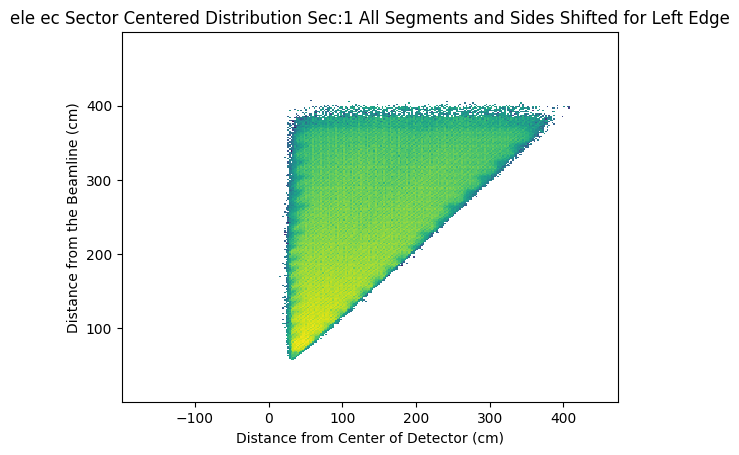

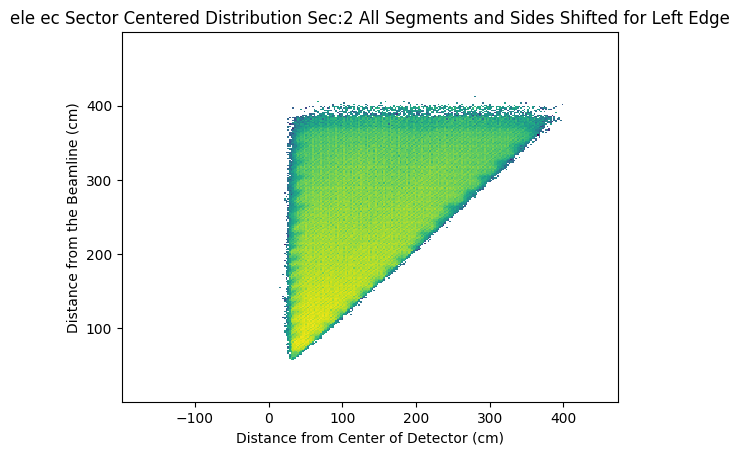

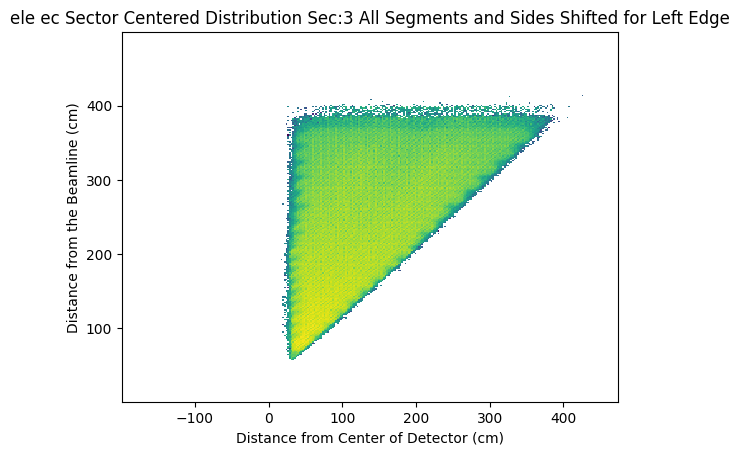

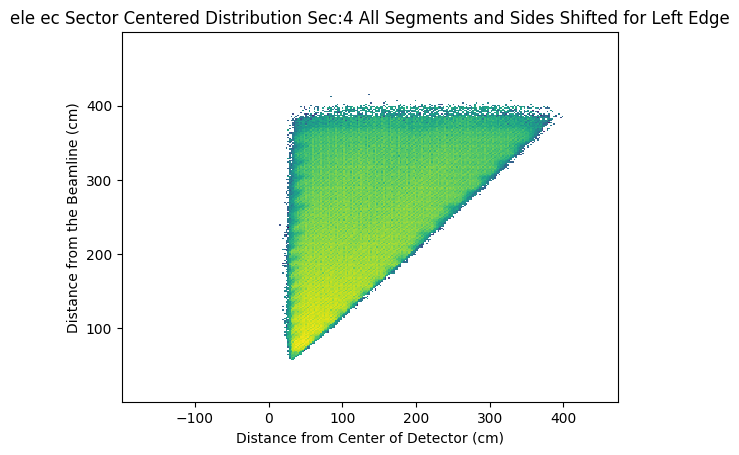

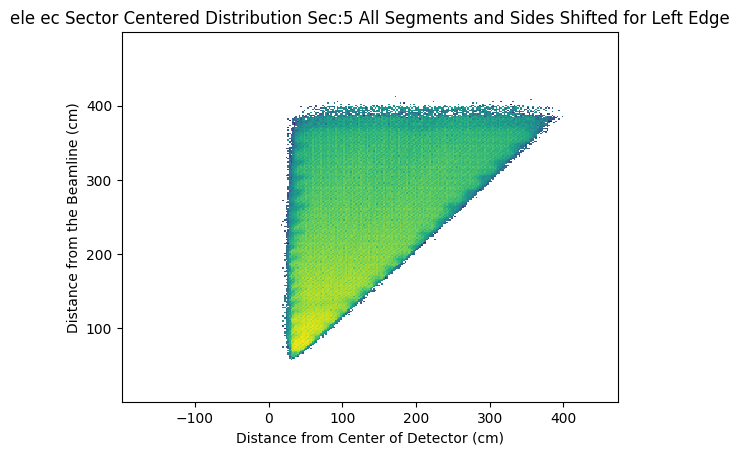

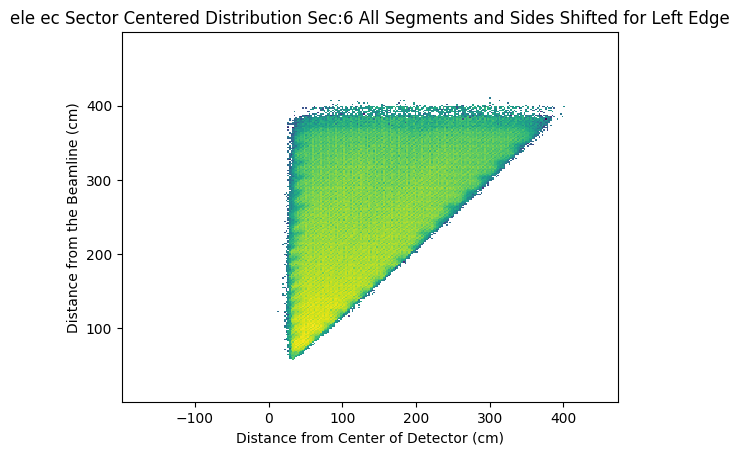

In [14]:
#Shifting for Left Edge
dumb1_x_sl= np.zeros((7,cut_hist_len,xdim*ydim))
dumb1_y_sl= np.zeros((7,cut_hist_len,xdim*ydim))
dense1_sl = np.zeros((7,cut_hist_len,xdim*ydim))
dumb2_x_sl= np.zeros((7,cut_hist_len,xdim*ydim))
dumb2_y_sl= np.zeros((7,cut_hist_len,xdim*ydim))
dense2_sl = np.zeros((7,cut_hist_len,xdim*ydim))
for sec in range(7):
    for i in range(xdim):
        for j in range(ydim):
            for hist_idx in range(cut_hist_len):
                dumb1_x_sl[sec][hist_idx][i+j*xdim]+=xvals[i]-yvals[j]/left_rot[sec]
                dumb1_y_sl[sec][hist_idx][i+j*xdim]+=yvals[j]
                dense1_sl[sec][hist_idx][i+j*xdim]+=zvals_xy[sec][hist_idx][i][j]
                dumb2_x_sl[sec][hist_idx][j+i*ydim]+=yvals[j]
                dumb2_y_sl[sec][hist_idx][j+i*ydim]+=xvals[i]-yvals[j]/left_rot[sec]
                dense2_sl[sec][hist_idx][j+i*ydim]+=zvals_yx[sec][hist_idx][j][i]
for sec in range(6):
    plt.hist2d(dumb1_x_sl[sec][cut_hist_len-1], dumb1_y_sl[sec][cut_hist_len-1], bins=(xdim, ydim), weights=dense1_sl[sec][cut_hist_len-1],norm = mpl.colors.LogNorm())
    plt.title(species+" "+detector+" Sector Centered Distribution Sec:{} All Segments and Sides Shifted for Left Edge".format(sec+1))
    plt.xlabel("Distance from Center of Detector (cm)")
    plt.ylabel("Distance from the Beamline (cm)")
    plt.show()

In [15]:
proj_y = np.zeros((7,cut_hist_len,ydim))
proj_xr = np.zeros((7,cut_hist_len,xdim))
proj_xl = np.zeros((7,cut_hist_len,xdim))
for sec in range(7):
    for i in range(ydim):
        for j in range(xdim):
            for hist_idx in range(cut_hist_len):
                proj_y[sec][hist_idx][i] += zvals_xy[sec][hist_idx][j][i]
                if j-shift_idx(yvals[i]/(3**(1/2))) > 0:
                    proj_xr[sec][hist_idx][j-shift_idx(yvals[i]/right_rot[sec])] += zvals_xy[sec][hist_idx][j][i]
                if j+shift_idx(yvals[i]/(3**(1/2))) < xdim-1:
                    proj_xl[sec][hist_idx][j-shift_idx(yvals[i]/left_rot[sec])] += zvals_xy[sec][hist_idx][j][i]

[-1.21914471e+01 -3.51787602e+01  5.05212161e+01  1.62378599e+05]


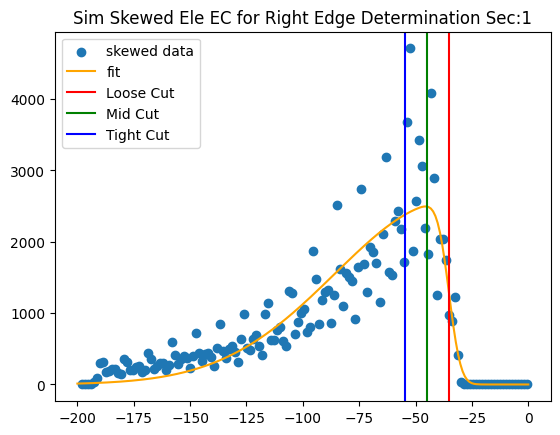

[-1.10879178e+01 -3.86058278e+01  6.54806924e+01  1.02279223e+05]


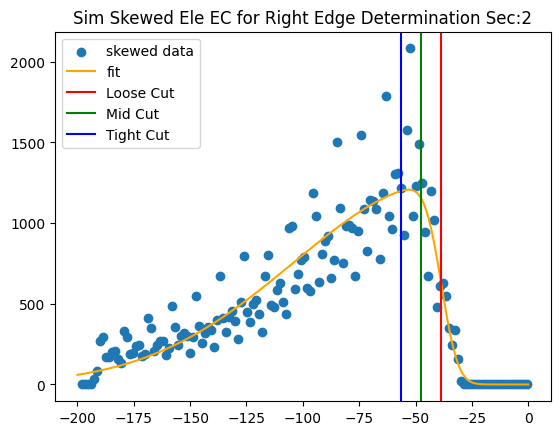

[-1.54390514e+01 -3.66604165e+01  7.64944627e+01  6.40207453e+04]


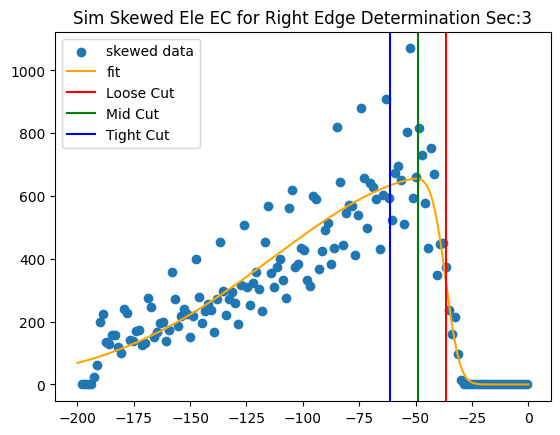

[-1.57709018e+01 -3.45940551e+01  5.79771250e+01  1.22754551e+05]


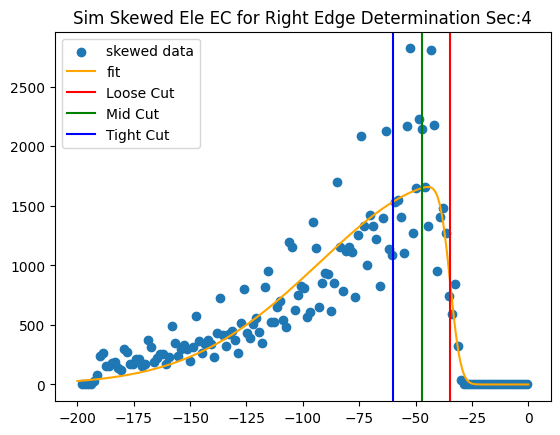

[-9.90036122e+00 -3.50118281e+01  4.22557863e+01  2.38160299e+05]


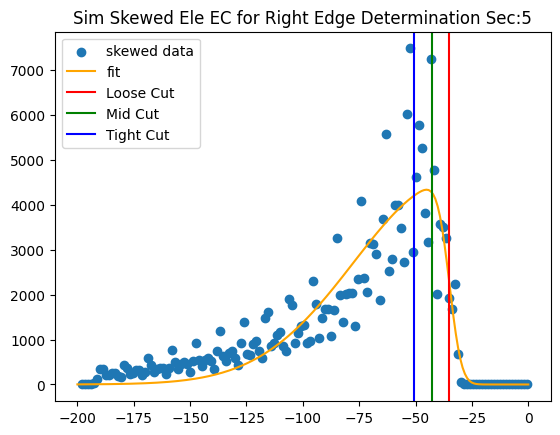

[-1.39874568e+01 -3.71212147e+01  6.42508787e+01  8.49362976e+04]


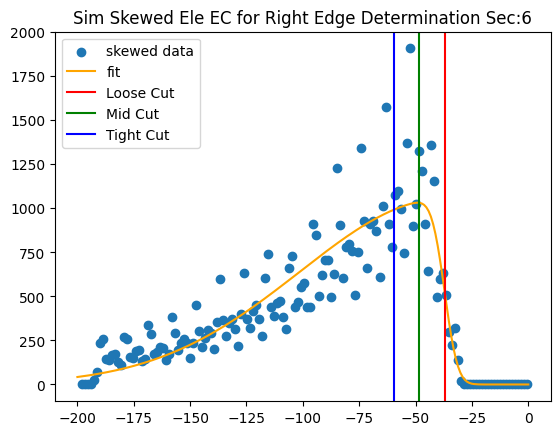

[-1.32551212e+01 -3.75498708e+01  5.71110924e+01  7.78203367e+05]


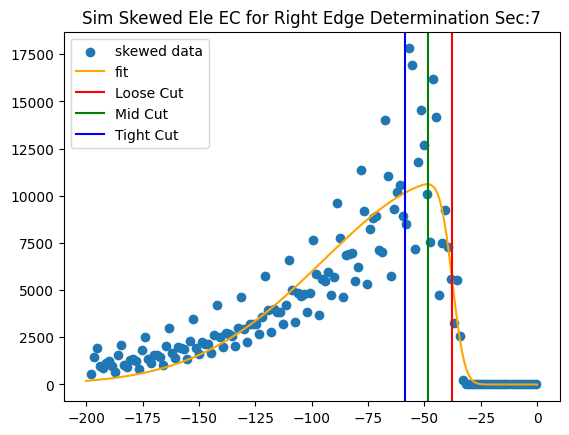

In [16]:
right_edge = [[-50.,-50,-50.] for i in range(7)]

ini_par = [-6.23,-41,54,51670]

#Bounds_on_Y(yarray_,low_,high_) removes all values not between or equal to bounds
#Bounds_on_X_From_Y(xarray_,yarray_,low_,high_) 

#skew_norm(x_,skew_,loc_,scale_,norm_)
for sec in range(7):
    mod_xvals = Bounds_on_Y(xvals,-198,0.0)
    mod_zvals = Bounds_on_X_From_Y(proj_xr[sec][0],xvals,-198,0.0)
    
    plt.scatter(mod_xvals,mod_zvals,label="skewed data")
    cont_x = np.linspace(-200,0,200)
    #plt.plot(cont_x,skew_norm(cont_x,*ini_par),label="ini_pars")
    try:
        pars, pars_cov = op.curve_fit(skew_norm,mod_xvals,mod_zvals,p0=ini_par,maxfev=5000)
        plt.plot(cont_x,skew_norm(cont_x,*pars),label="fit",color='orange')
        print(pars)
        right_edge[sec][2] = pars[1]
        right_edge[sec][1] = pars[1]+0.8*pars[0]
        right_edge[sec][0] = pars[1]+1.6*pars[0]
    except RuntimeError:
        print("Runtime Error")
    except ValueError:
        print("Value Error")
    plt.axvline(x=right_edge[sec][2],label="Loose Cut",color='r')
    plt.axvline(x=right_edge[sec][1],label="Mid Cut",color='g')
    plt.axvline(x=right_edge[sec][0],label="Tight Cut",color='b')
    plt.title("Sim Skewed Ele EC for Right Edge Determination Sec:{}".format(sec+1))
    plt.legend()
    plt.show()

[1.19459482e+01 3.55261174e+01 4.99489636e+01 1.62630078e+05]


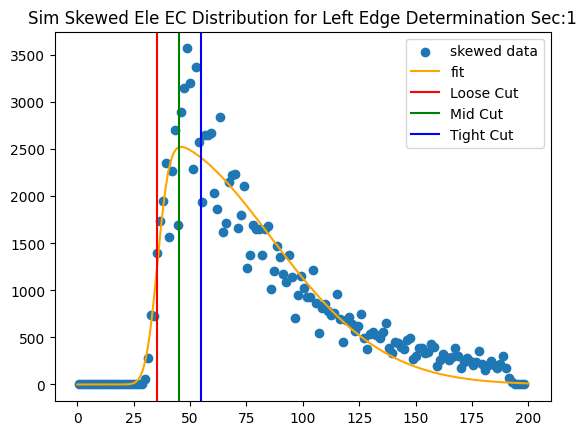

[1.17286293e+01 3.75566597e+01 6.70416614e+01 1.03105799e+05]


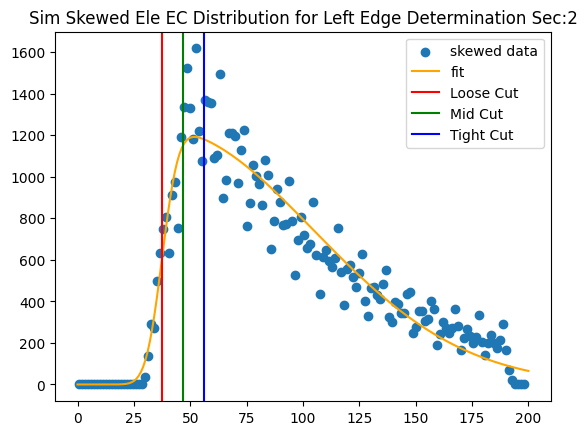

[1.37192120e+01 3.71760506e+01 7.41019703e+01 6.34037470e+04]


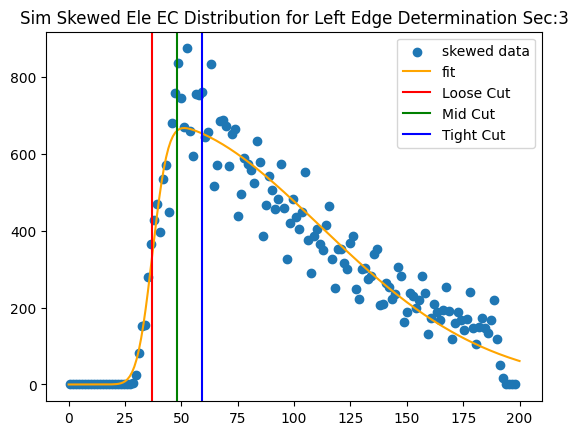

[1.18652235e+01 3.63651196e+01 5.57509133e+01 1.21771479e+05]


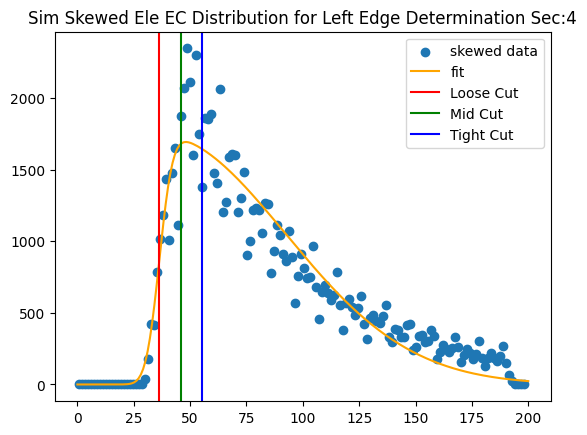

[1.32552680e+01 3.44303014e+01 4.16262275e+01 2.38077404e+05]


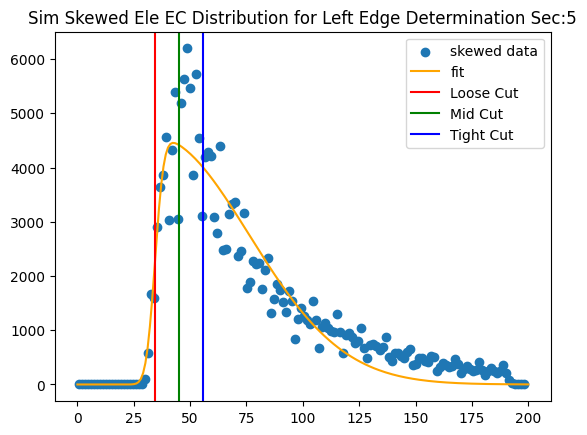

[1.20131762e+01 3.75302110e+01 6.49222939e+01 8.51137955e+04]


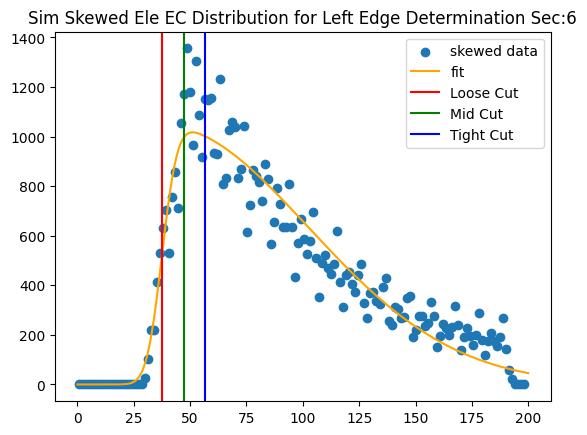

[1.66126095e-02 2.52871509e+02 6.87847914e+01 2.15462472e+05]


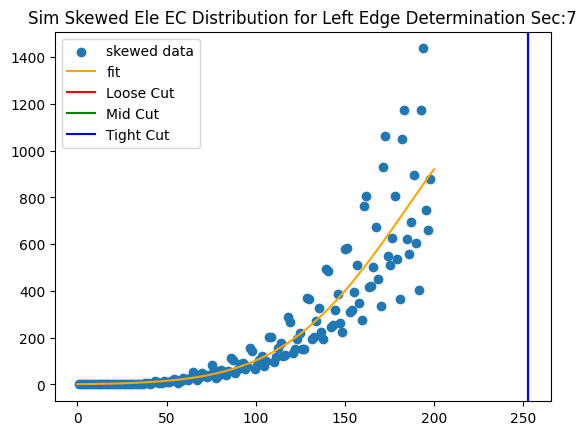

In [17]:
left_edge = [[50.,50,50.] for i in range(7)]

ini_par = [6.23,41,54,51670]

for sec in range(7):
    mod_xvals = Bounds_on_Y(xvals,0.0,198)
    mod_zvals = Bounds_on_X_From_Y(proj_xl[sec][0],xvals,0.0,198)
    
    plt.scatter(mod_xvals,mod_zvals,label="skewed data")
    cont_x = np.linspace(0.0,200,200)
    #plt.plot(cont_x,skew_norm(cont_x,*ini_par),label="ini_pars")
    try:
        pars, pars_cov = op.curve_fit(skew_norm,mod_xvals,mod_zvals,p0=ini_par,maxfev=5000)
        plt.plot(cont_x,skew_norm(cont_x,*pars),label="fit",color='orange')
        print(pars)
        left_edge[sec][2] = pars[1]
        left_edge[sec][1] = pars[1]+0.8*pars[0]
        left_edge[sec][0] = pars[1]+1.6*pars[0]
    except RuntimeError:
        print("Runtime Error")
    except ValueError:
        print("Value Error")
    plt.axvline(x=left_edge[sec][2],label="Loose Cut",color='r')
    plt.axvline(x=left_edge[sec][1],label="Mid Cut",color='g')
    plt.axvline(x=left_edge[sec][0],label="Tight Cut",color='b')
    plt.title("Sim Skewed Ele EC Distribution for Left Edge Determination Sec:{}".format(sec+1))
    plt.legend()
    plt.show()

In [18]:
def exp_off(x_, a_, mu_,d_):
    return a_*np.exp(-(x_-mu_)/d_)

def exp_off_edge(comp_,frac_, a_, mu_, d_):
    return -d_*(math.log(frac_)-((comp_-mu_)/d_)-(mu_/d_))

[1.01417644e+04 3.10921615e+02 1.01148325e+01]


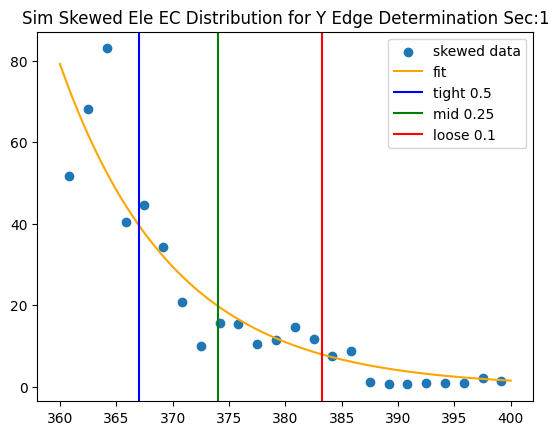

[8821.68203336  312.90977348    9.98322839]


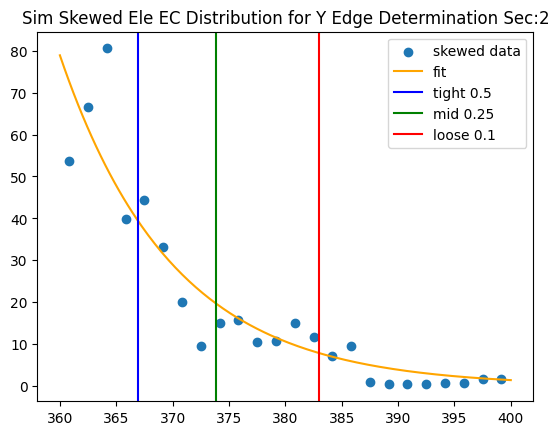

[7870.38803223  312.16677048   10.43877281]


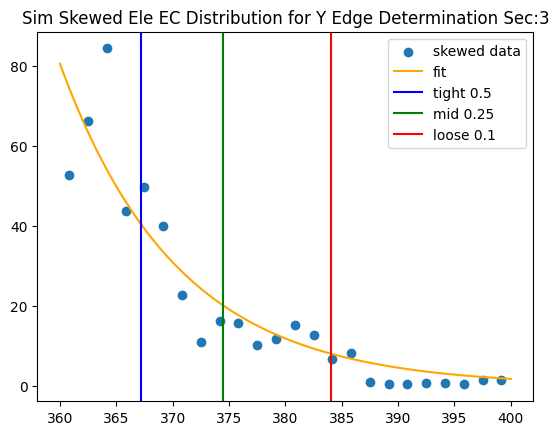

[10134.5875732    309.53982444    10.22644287]


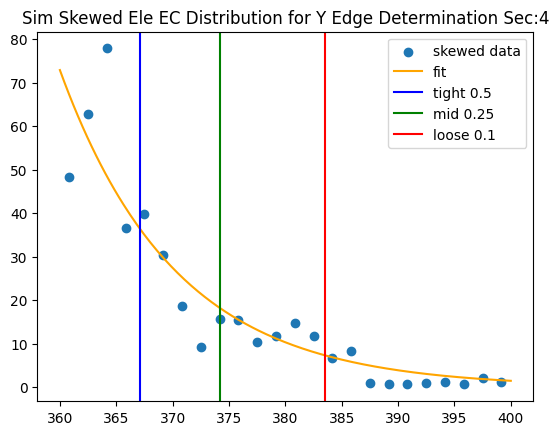

[7944.94142432  312.47221028   10.43023709]


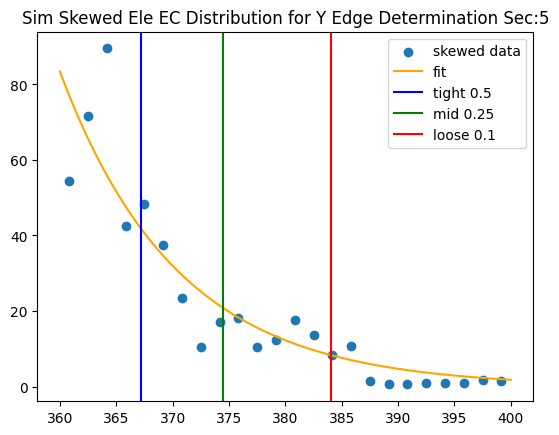

[6734.23279591  315.87758146    9.75241476]


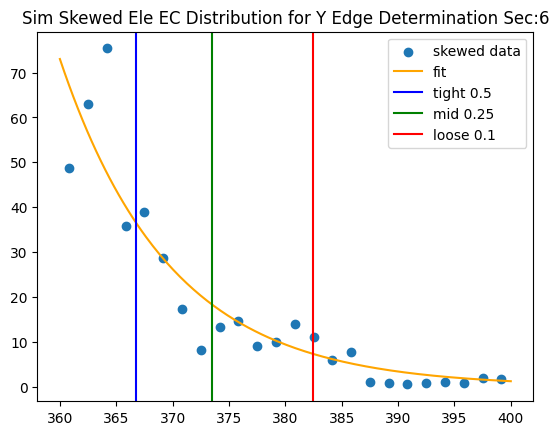

[5448.06008513  335.03600166   10.16894988]


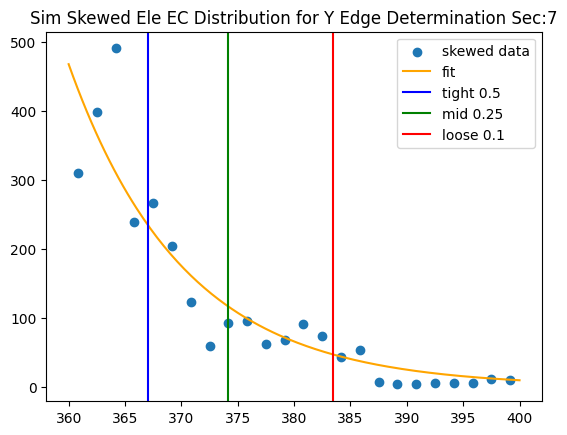

In [19]:
y_edge = np.zeros((7,3))

ini_par = [1359.29693959,  184.29431595,   43.19563841]

bou_y = [360.0,400.0]

comp_x = 360.0

frac_y = [0.5,0.25,0.1]

for sec in range(7):
    mod_xvals = Bounds_on_Y(yvals,bou_y[0],bou_y[1])
    mod_zvals = Bounds_on_X_From_Y(proj_y[sec][0],yvals,bou_y[0],bou_y[1])
    
    plt.scatter(mod_xvals,mod_zvals,label="skewed data")
    cont_x = np.linspace(bou_y[0],bou_y[1],200)
    #plt.plot(cont_x,skew_norm(cont_x,*ini_par),label="ini_pars")
    try:
        pars, pars_cov = op.curve_fit(exp_off,mod_xvals,mod_zvals,p0=ini_par,maxfev=5000)
        plt.plot(cont_x,exp_off(cont_x,*pars),label="fit",color='orange')
        print(pars)
        for cut in range(3):
            y_edge[sec][cut] = exp_off_edge(comp_x,frac_y[cut],*pars)
    except RuntimeError:
        print("Runtime Error")
    except ValueError:
        print("Value Error")
    for cut in range(3):
        plt.axvline(x=y_edge[sec][cut],label="{} {}".format(cut_name[cut],frac_y[cut]),color=color_order[cut])
    plt.title("Sim Skewed Ele EC Distribution for Y Edge Determination Sec:{}".format(sec+1))
    plt.legend()
    plt.show()

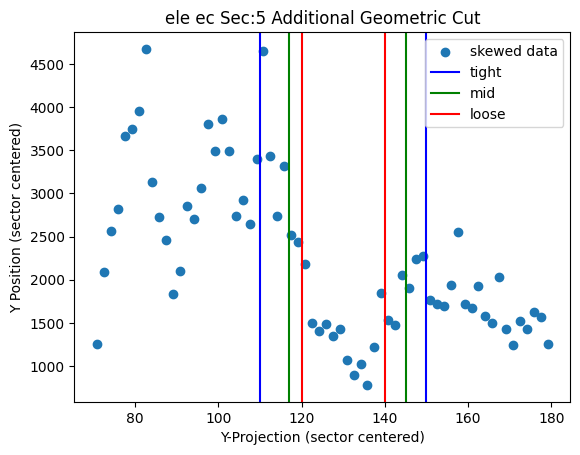

In [20]:
#Additional Cut on Sector 5 Needed
#manually adjusted
vert_cuts = [[110,150],[117,145],[120,140]]
#Done by hand

sec = 4
bou = [70,180]
mod_xvals = Bounds_on_Y(yvals,bou[0],bou[1])
mod_zvals = Bounds_on_X_From_Y(proj_y[sec][0],yvals,bou[0],bou[1])
plt.scatter(mod_xvals,mod_zvals,label="skewed data")
for cut in range(3):
    plt.axvline(x=vert_cuts[cut][0],color=color_order[cut],label=cut_name[cut])
    plt.axvline(x=vert_cuts[cut][1],color=color_order[cut])
plt.title(species+" "+detector+" Sec:{} Additional Geometric Cut".format(sec+1))
plt.xlabel("Y-Projection (sector centered)")
plt.ylabel("Y Position (sector centered)")
plt.legend()
plt.show()

sec_5_cuts = [[vert_cuts[cut][0],vert_cuts[cut][1]] for cut in range(3)]

In [21]:
def super_gaus_cut_bound(frac_,side_,a_,m_,s_,p_):
    if side_ == 0:
        return 0.5*(2*m_ - 2 * (math.log(1./frac_)**(1./p_))*(2**(p_/2.)*(1./s_)**(-p_))**(1./p_))
    elif side_ ==1:
        return 0.5*(2*m_ + 2 * (math.log(1./frac_)**(1./p_))*(2**(p_/2.)*(1./s_)**(-p_))**(1./p_))
    else:
        return -99.9
    

def Sup_Gaus_Cutoff(x_,frac_,a_,m_,s_,p_):
    if x < super_gaus_cut_bound(frac_,0,a_,m_,s_,p_):
        return 0.
    elif x > super_gaus_cut_bound(frac_,1,a_,m_,s_,p_):
        return 0.
    else:
        return Super_Gaus(x_,a_,m_,s_,p_)
    
def Sup_Gaus_Cutoff_Array(x_,frac_,a_,m_,s_,p_):
    output = np.zeros(len(x_))
    for i in range(len(x_)):
        output[i] = Sup_Gaus_Cutoff(x_[i],frac_,a_,m_,s_,p_)
    return output

[[[99.06716600826657, 1.8115942028985508], [81.39840203278325, 1.8115942028985508], [63.72963805729994, 1.8115942028985508]], [[102.07698603380359, 1.8115942028985508], [86.00753993357772, 1.8115942028985508], [69.93809383335183, 1.8115942028985508]], [[111.16467147980046, 1.8115942028985508], [88.78923471909172, 1.8115942028985508], [66.41379795838299, 1.8115942028985508]], [[108.38314851386848, 1.8115942028985508], [85.52676905227824, 1.8115942028985508], [62.670389590687996, 1.8115942028985508]], [[92.12392407511348, 1.8115942028985508], [77.77557448304947, 1.8115942028985508], [63.42722489098544, 1.8115942028985508]], [[107.79193051176452, 1.8115942028985508], [87.52025395421, 1.8115942028985508], [67.2485773966555, 1.8115942028985508]], [[101.77195343916935, 1.7320508075688772], [83.40511870830447, 1.7320508075688772], [65.03828397743958, 1.7320508075688772]]]
[[99.06716600826657, 1.8115942028985508], [81.39840203278325, 1.8115942028985508], [63.72963805729994, 1.8115942028985508]

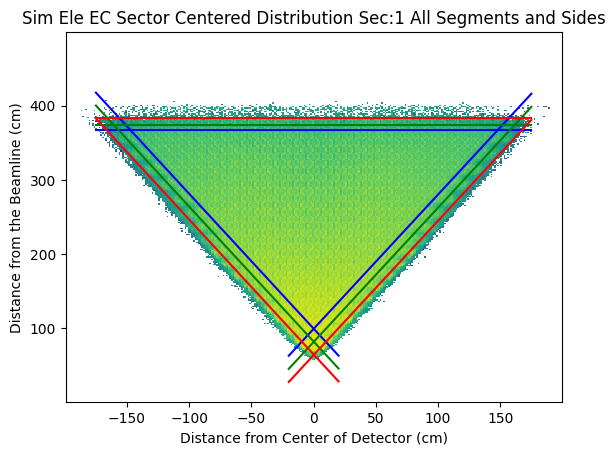

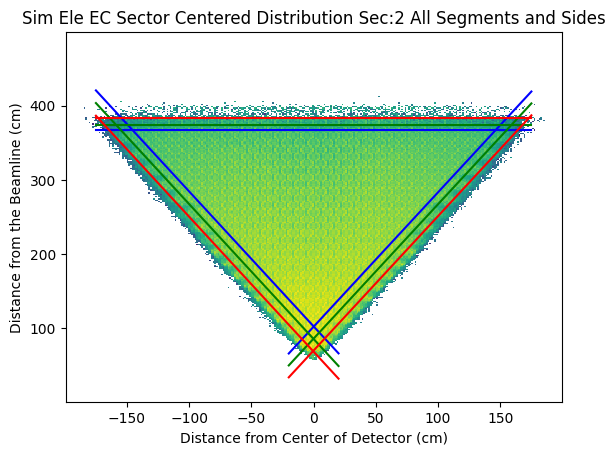

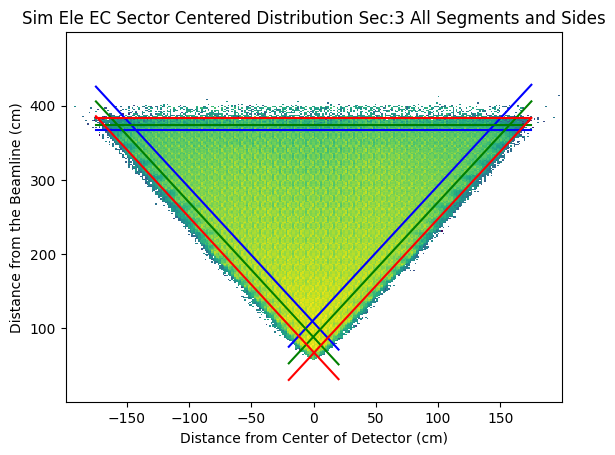

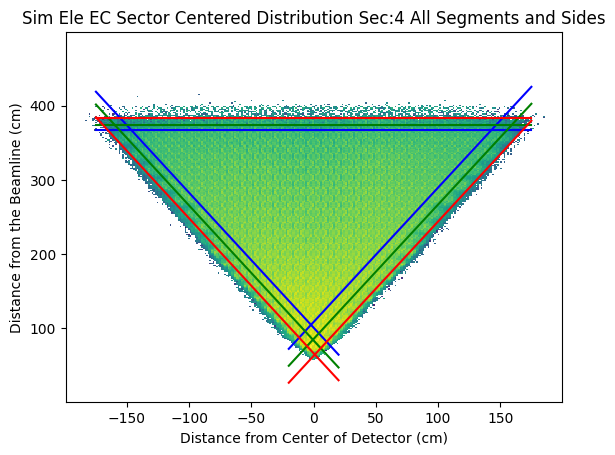

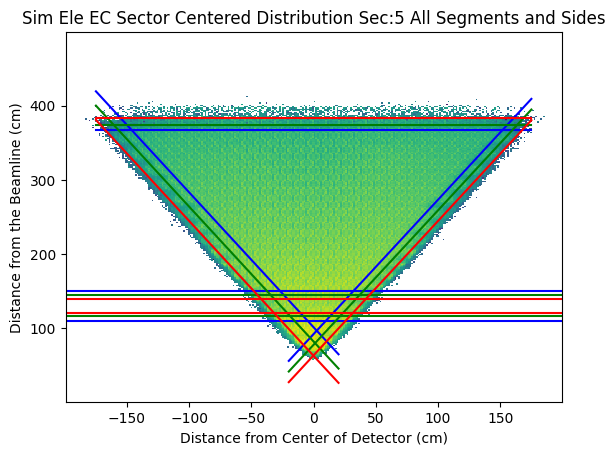

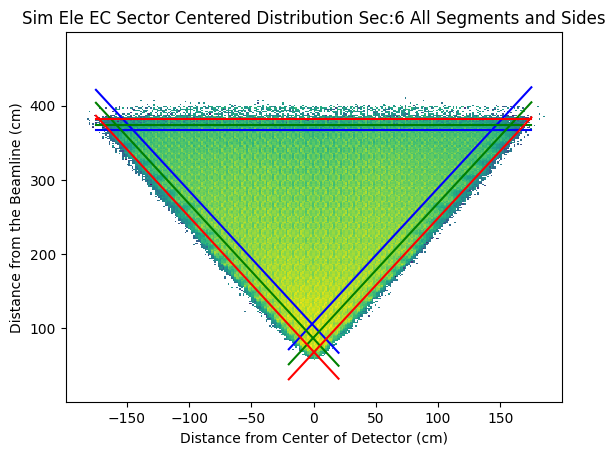

In [23]:
right_cut_pars = [[[-right_edge[sec][cut_idx]*right_rot[sec],right_rot[sec]] for cut_idx in range(3)] for sec in range(7)]
left_cut_pars = [[[left_edge[sec][cut_idx]*(-left_rot[sec]),left_rot[sec]] for cut_idx in range(3)] for sec in range(7)]

#side_cut_pars = [[[-right_edge[sec][cut_idx1]*3**(1/2),3**(1/2)] for cut_idx1 in range(3)],[[left_edge[sec][cut_idx2]*3**(1/2),-(3**(1/2))] for cut_idx2 in range(3)] for sec in range(7)]

print(right_cut_pars)
print(right_cut_pars[0])

cont_x_r = np.linspace(-20.0,175.,200)
cont_x_l = np.linspace(-175.0,20.,200)

for sec in range(6):
    plt.hist2d(dumb1_x[sec][cut_hist_len-1], dumb1_y[sec][cut_hist_len-1], bins=(xdim, ydim), weights=dense1[sec][cut_hist_len-1],norm = mpl.colors.LogNorm())
    for cut in range(3):
        plt.plot(cont_x_r,Poly(cont_x_r,right_cut_pars[sec][cut]),label=cut_name[cut],color=color_order[cut])
        plt.plot(cont_x_l,Poly(cont_x_l,left_cut_pars[sec][cut]),color=color_order[cut])
        plt.plot([-175,175],[y_edge[sec][cut],y_edge[sec][cut]],color=color_order[cut])
        if sec == 4:
            #sec_5_cuts = [[vert_cuts[cut][0],vert_cuts[cut][1]] for cut in range(3)]
            plt.axhline(y=sec_5_cuts[cut][0],color=color_order[cut])
            plt.axhline(y=sec_5_cuts[cut][1],color=color_order[cut])
    plt.title("Sim Ele EC Sector Centered Distribution Sec:{} All Segments and Sides".format(sec+1))
    plt.xlabel("Distance from Center of Detector (cm)")
    plt.ylabel("Distance from the Beamline (cm)")
    plt.show()


In [36]:
print("Cut Parameters for "+species+" "+detector+" Geometric Cut")
print("side_cut_par[sec][tight,mid,loose][right,left][intercept,slope]")

for sec in range(6):
    for cut in range(3):
        if cut == 0:
            if sec ==0:
                print("{\t{\t{\t{",right_cut_pars[sec][cut][0],",",right_cut_pars[sec][cut][1],"},{",left_cut_pars[sec][cut][0],",",left_cut_pars[sec][cut][1],"}},")
            else:
                print("\t{\t{\t{",right_cut_pars[sec][cut][0],",",right_cut_pars[sec][cut][1],"},{",left_cut_pars[sec][cut][0],",",left_cut_pars[sec][cut][1],"}},")
        elif cut ==2:
            if sec == 5:
                print("\t\t{\t{",right_cut_pars[sec][cut][0],",",right_cut_pars[sec][cut][1],"},{",left_cut_pars[sec][cut][0],",",left_cut_pars[sec][cut][1],"}}}}")
            else:
                print("\t\t{\t{",right_cut_pars[sec][cut][0],",",right_cut_pars[sec][cut][1],"},{",left_cut_pars[sec][cut][0],",",left_cut_pars[sec][cut][1],"}}},")
        else:
            print("\t\t{\t{",right_cut_pars[sec][cut][0],",",right_cut_pars[sec][cut][1],"},{",left_cut_pars[sec][cut][0],",",left_cut_pars[sec][cut][1],"}},")
    
        
        

Cut Parameters for ele ec Geometric Cut
side_cut_par[sec][tight,mid,loose][right,left][intercept,slope]
{	{	{	{ 99.06716600826657 , 1.8115942028985508 },{ 99.34478995080542 , -1.8181818181818181 }},
		{	{ 81.39840203278325 , 1.8115942028985508 },{ 81.96886535892244 , -1.8181818181818181 }},
		{	{ 63.72963805729994 , 1.8115942028985508 },{ 64.59294076703945 , -1.8181818181818181 }}},
	{	{	{ 102.07698603380359 , 1.8115942028985508 },{ 102.40448454358513 , -1.8181818181818181 }},
		{	{ 86.00753993357772 , 1.8115942028985508 },{ 85.34466013973888 , -1.8181818181818181 }},
		{	{ 69.93809383335183 , 1.8115942028985508 },{ 68.28483573589261 , -1.8181818181818181 }}},
	{	{	{ 111.16467147980046 , 1.8115942028985508 },{ 107.50325411485338 , -1.8181818181818181 }},
		{	{ 88.78923471909172 , 1.8115942028985508 },{ 87.54803669006706 , -1.8181818181818181 }},
		{	{ 66.41379795838299 , 1.8115942028985508 },{ 67.59281926528075 , -1.8181818181818181 }}},
	{	{	{ 108.38314851386848 , 1.8115942028985508 }

In [35]:
print("Top Cut for "+species+" "+detector+" Geometric Cut")
print("[sec][tight,mid,loose]")
for sec in range(6):
    for cut in range(3):
        if cut==0:
            if sec == 0:
                print("{\t{",y_edge[sec][cut],end=",")
            else:
                print("\t{",y_edge[sec][cut],end=",")
        elif cut==2:
            if sec == 5:
                print(y_edge[sec][cut],"}}")
            else:
                print(y_edge[sec][cut],"},")
        else:
            print(y_edge[sec][cut],end=",")
            

Top Cut for ele ec Geometric Cut
[sec][tight,mid,loose]
{	{ 367.01106761415457,374.02213522830914,383.29026248261493 },
	{ 366.91984661474453,373.83969322948894,382.9872328818309 },
	{ 367.23560593964885,374.47121187929775,384.03616265445345 },
	{ 367.0884300426248,374.17686008524964,383.547254907239 },
	{ 367.2296894346409,374.4593788692818,384.01650845024386 },
	{ 366.759858796269,373.51971759253803,382.45576485279736 }}


In [34]:
print("Sector 5 efficiency cut")
print("[tight,mid,loose][bot,top]")
for cut in range(3):
    if cut==0:
        print("{\t{",sec_5_cuts[cut][0],",",sec_5_cuts[cut][1],"},")
    elif cut==2:
        print("\t{",sec_5_cuts[cut][0],",",sec_5_cuts[cut][1],"}}")
    else:
        print("\t{",sec_5_cuts[cut][0],",",sec_5_cuts[cut][1],"},")
    
                                                                      

Sector 5 efficiency cut
[tight,mid,loose][bot,top]
{	{ 110 , 150 },
	{ 117 , 145 },
	{ 120 , 140 }}
